### Choose your path

In [65]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [14]:
current_dir = "/Users/sergiopeignier/Desktop/INSA/BF2I_RESEARCH/GREEN_SHIELD/spectres/"

### Choose your file

In [2]:
exp_name ="NA9R2F" #"VL1gr"#"VL1grF"



### Load libraries

In [4]:
%matplotlib inline
import spectral as sp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from spectrum import scale_white_dark,plot_spectra

###  Get wave lengths

In [5]:
wave_lengths = pd.read_csv("data_training/wave_lengths.csv",index_col=0,header=None)[1]

### Load the image

In [15]:
image_path = current_dir+exp_name+'/capture/'+exp_name+'.hdr'
dark_ref_path = current_dir+exp_name+'/capture/DARKREF_'+exp_name+'.hdr'
white_ref_path = current_dir+exp_name+'/capture/WHITEREF_'+exp_name+'.hdr'

In [16]:
img = sp.open_image(image_path)

dark_ref = sp.open_image(dark_ref_path)
dark_spectrum = dark_ref.asarray().reshape(-1,dark_ref.shape[2]).mean(axis=0)

white_ref = sp.open_image(white_ref_path)
white_spectrum = white_ref.asarray().reshape(-1,white_ref.shape[2]).mean(axis=0)

/Users/sergiopeignier/opt/anaconda3/lib/python3.9/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


### Normalize

In [17]:
img_norm = scale_white_dark(img.asarray(),dark_spectrum=dark_spectrum,white_spectrum=white_spectrum)

In [18]:
img_norm_reshape = img_norm.reshape(-1,img_norm.shape[-1])
img_norm_reshape.shape

(977920, 448)

In [19]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_original = img_norm_reshape.copy()
img_norm_reshape = ss.fit_transform(X=img_norm_reshape.T)
img_norm_reshape = img_norm_reshape.T

### Plot the image

(955, 1024, 448)


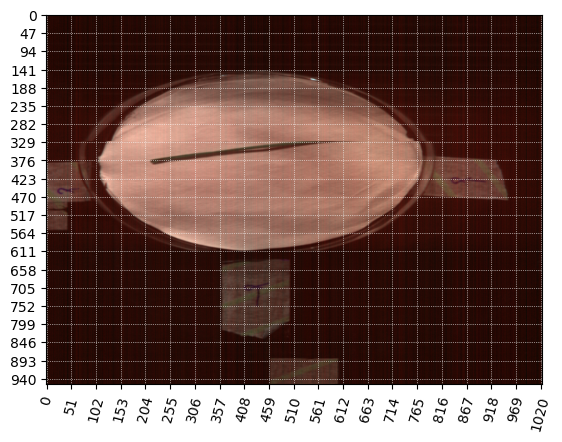

In [27]:
print(img.shape) 
def plot_spectra(img, wave_lengths=(29,112,226), grid_step=20):
    sp.imshow(img, wave_lengths,aspect="auto")
    ax = plt.gca()
    ax.set_xticks(np.arange(0, img.shape[1], int(img.shape[1]/grid_step)))
    ax.set_yticks(np.arange(0, img.shape[0], int(img.shape[0]/grid_step)))
    plt.xticks(rotation=75)
    ax.grid(color='white', linestyle=':', linewidth=0.5)
    #plt.xlabel("y",fontsize=15)
    #plt.ylabel("x",fontsize=15)
plot_spectra(img,wave_lengths=(33,109,139), grid_step=20)
#plt.savefig('raw_image.png')

# Apply OC-SVM model to full image

In [28]:
from joblib import dump, load
svm = load('models/OCSVM_model.joblib')

In [31]:
%timeit Zz = svm.decision_function(img_norm_reshape)

3.3 s ± 44.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%timeit Z = svm.score_samples(img_norm_reshape)

3.31 s ± 44.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


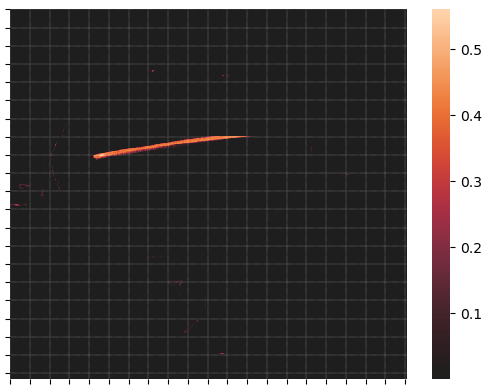

In [35]:
sns.heatmap((Z*(Z>0)).reshape(img_norm.shape[:2]),center=0)
ax = plt.gca()
grid_step = 20
ax.set_xticks(np.arange(0, img.shape[1], int(img.shape[1]/grid_step)))
ax.set_yticks(np.arange(0, img.shape[0], int(img.shape[0]/grid_step)))
plt.xticks(rotation=75)
ax.grid(color='w', linestyle=':', linewidth=0.3)    
#plt.savefig('scores_aphids_group.png')

In [36]:
Z_pd = pd.DataFrame(Z.reshape(img_norm.shape[:2]))
Z_pd = Z_pd.stack().reset_index(name='Score')

(-0.5, 1023.5, 954.5, -0.5)

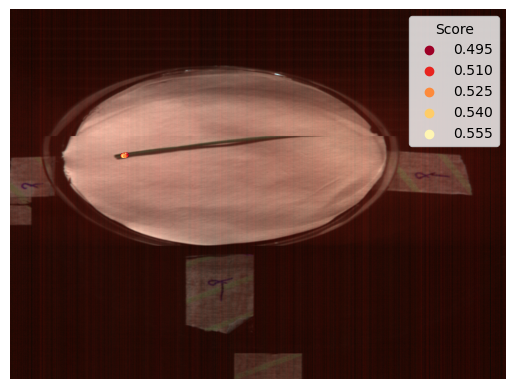

In [43]:
plot_spectra(img,  wave_lengths=(33,109,139), grid_step=20)
sns.scatterplot(data=Z_pd[Z_pd["Score"]>=0.49],
                x="level_1", y="level_0", hue="Score",linewidth=0.,
                marker="o",s=5,alpha=1,
                palette =sns.color_palette("YlOrRd_r", as_cmap=True))
plt.axis('off')

(-0.5, 1023.5, 954.5, -0.5)

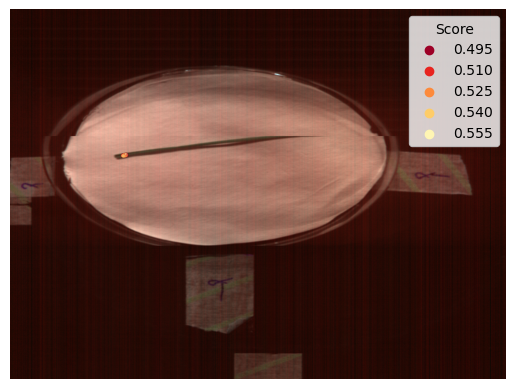

In [39]:
plot_spectra(img,  wave_lengths=(33,109,139), grid_step=20)
sns.scatterplot(data=Z_pd[Z_pd["Score"]>0.49],
                x="level_1", y="level_0", hue="Score",linewidth=0.,
                marker="o",s=4,alpha=0.3,
                palette =sns.color_palette("YlOrRd_r", as_cmap=True))
plt.axis('off')
#plt.savefig("aphids_groups.pdf")

# Apply LoG Blob detection 

In [44]:
from skimage.feature import blob_log,blob_dog
blobs = blob_log((Z*(Z>=0.49)).reshape(img_norm.shape[:2]),
                 max_sigma=20,threshold=0.01,
                 min_sigma=3,overlap=0.9
                )


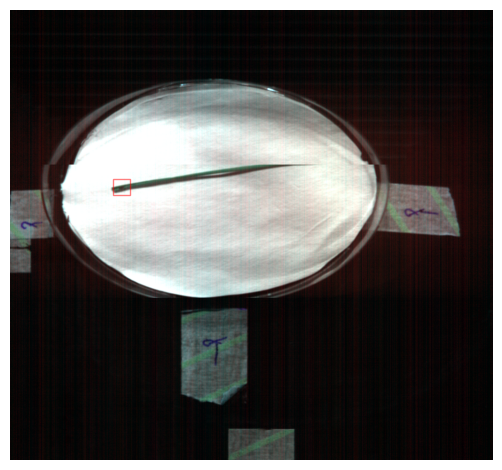

In [45]:
fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
ax.imshow(img_norm[:,:,(33,109,139)])
#plot_spectra(img,  wave_lengths=(33,109,139), grid_step=20)
#sns.heatmap((Z*(Z>0)).reshape(img_norm.shape[:2]),center=0)
size = 35
for blob in blobs:
    y, x, r = blob
    #plt.plot((x),((y)))
    c = plt.Rectangle((x-size//2-1, y-size//2-1),size,
                      size, color="red", linewidth=1,
                      alpha=0.5,fill=False)
    ax.add_patch(c)
ax.set_axis_off()
plt.tight_layout()
#plt.savefig("figures_group_aphids/aphids_groups_white_dog.pdf")

In [46]:
len(blobs)

1